## Tutorial Introdutório de Pytorch (v5)

Tutorial baseado no código disponibilizado por Sagi Eppel [aqui](https://towardsdatascience.com/train-neural-net-for-semantic-segmentation-with-pytorch-in-50-lines-of-code-830c71a6544f)

Principais funcionalidades:

- Exemplo de segmentação semântica usando o pytorch
- Transferência de aprendizado usando a DeepLabV3 pré-treinada
- Informações de desempenho da segmentação (acurácia pixel a pixel e matriz 
  de confusão)

Imagens para treinamento, validação e teste:

- Precisam estar dentro de uma pasta no seu drive chamada compara_segmentadores/data/imagens/

Anotações para treinamento, validação e teste:

- Precisam estar dentro de uma pasta no seu drive chamada compara_segmentadores/data/anotacoes/
- Precisam ter o mesmo nome da imagem correspondente que está na pasta de imagens, mas com extensão .png
- Precisa ser uma imagem em tons de cinza (1 canal) com o valor de pixel correspondente a cada classe do problema. Por exemplo: 0 = Fundo, 1 = Serpente
- O código está assumindo apenas duas classes e realiza uma binarização na imagem de anotação
 

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models.segmentation as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score, accuracy_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

# Defina o caminho para o diretório contendo as imagens e as anotações
diretorio_dados = "/content/gdrive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/tudo/"

# Defina as configurações do treinamento
epocas = 10
tamanho_lote = 4
taxa_aprendizagem = 0.001
momento = 0.9
paciencia = 3

# Defina as classes alvo
classes = ["classe1", "classe2", "classe3"]

# Crie as transformações de pré-processamento
transformacoes = transforms.Compose([
    transforms.ToTensor(),
    # Adicione outras transformações, se necessário
])

# Carregue os nomes dos arquivos de imagem e anotação
nomes_imagens = os.listdir(os.path.join(diretorio_dados, "ti"))
nomes_anotacoes = os.listdir(os.path.join(diretorio_dados, "anotacoes"))

# Verifique se os nomes correspondem
nomes_todas = [nome for nome in nomes_imagens if nome in nomes_anotacoes]

# Separe os conjuntos de treinamento, validação e teste
perc_val = 0.2
perc_teste = 0.1

train_idx, test_idx = train_test_split(list(range(len(nomes_todas))), test_size=perc_teste)
nomes_teste = [nomes_todas[i] for i in test_idx]

test_other_idx, val_idx = train_test_split(list(range(len(test_idx))), test_size=perc_val)
nomes_val = [nomes_teste[i] for i in val_idx]

nomes_treinamento = [nomes_teste[i] for i in test_other_idx]

print("Tamanho dos conjuntos:")
print("Treinamento:", len(nomes_treinamento))
print("Validação:", len(nomes_val))
print("Teste:", len(nomes_teste))

class FCN(nn.Module):
    def __init__(self, num_classes):
        super(FCN, self).__init__()
        self.model = models.fcn_resnet50(pretrained=False, num_classes=num_classes)

    def forward(self, x):
        x = self.model(x)["out"]
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for i, data in enumerate(dataloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels.long())
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(dataloader)

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0

    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels.long())

            running_loss += loss.item()

    return running_loss / len(dataloader)

def test(model, dataloader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            y_true.extend(labels.tolist())
            y_pred.extend(predicted.tolist())

    precision, recall, fscore, _ = score(y_true, y_pred, average="weighted")
    accuracy = accuracy_score(y_true, y_pred)

    return precision, recall, fscore, accuracy

def plot_confusion_matrix(y_true, y_pred, classes):
    cm = metrics.confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(10, 7))
    sn.heatmap(df_cm, annot=True, fmt="d")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.show()

# Crie os objetos Dataset para carregar as imagens e anotações
dataset_treinamento = datasets.ImageFolder(os.path.join(diretorio_dados, "imagens"), transform=transformacoes)
dataset_validacao = datasets.ImageFolder(os.path.join(diretorio_dados, "imagens"), transform=transformacoes)
dataset_teste = datasets.ImageFolder(os.path.join(diretorio_dados, "imagens"), transform=transformacoes)

# Crie os objetos DataLoader para carregar os conjuntos de dados
dataloader_treinamento = torch.utils.data.DataLoader(dataset_treinamento, batch_size=tamanho_lote, sampler=train_sampler)
dataloader_validacao = torch.utils.data.DataLoader(dataset_validacao, batch_size=tamanho_lote, sampler=validacao_sampler)
dataloader_teste = torch.utils.data.DataLoader(dataset_teste, batch_size=tamanho_lote, sampler=teste_sampler)

# Crie o modelo e mova-o para o dispositivo de processamento
model = FCN(len(classes)).to(device)

# Defina a função de perda e o otimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=taxa_aprendizagem, momentum=momento)

melhor_precisao = 0.0
epocas_sem_melhora = 0
train_loss = []
val_loss = []

for epoch in range(epocas):
    print("Época:", epoch + 1)

    loss_treinamento = train(model, dataloader_treinamento, criterion, optimizer, device)
    loss_validacao = validate(model, dataloader_validacao, criterion, device)

    print("Loss - Treinamento:", loss_treinamento)
    print("Loss - Validação:", loss_validacao)

    train_loss.append(loss_treinamento)
    val_loss.append(loss_validacao)

    if loss_validacao < melhor_precisao:
        epocas_sem_melhora += 1
    else:
        melhor_precisao = loss_validacao
        epocas_sem_melhora = 0
        torch.save(model.state_dict(), "melhor_modelo.pt")

    if epocas_sem_melhora == paciencia:
        print("Treinamento interrompido devido à falta de melhora.")
        break

# Carregue o modelo com o menor erro de validação
model.load_state_dict(torch.load("melhor_modelo.pt"))

# Avalie o modelo no conjunto de teste
precision, recall, fscore, accuracy = test(model, dataloader_teste, device)
print("Precisão - Teste:", precision)
print("Revocação - Teste:", recall)
print("F-Score - Teste:", fscore)
print("Acurácia - Teste:", accuracy)

# Crie as previsões para o conjunto de teste
y_true, y_pred = [], []
with torch.no_grad():
    for data in dataloader_teste:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Plote a matriz de confusão
plot_confusion_matrix(y_true, y_pred, classes)


ValueError: ignored

In [ ]:
caminho_anotacao = 'oi/se'
caminho_anotacao = caminho_anotacao+'/anotacoes'
print(caminho_anotacao)

oi/se/anotacoes


## Carregando um banco de imagens

In [ ]:
import torch   # Pytorch principal
from torch import nn  # Módulo para redes neurais (neural networks)
import os      # Funções para manipulação de pastas e arquivos
import numpy as np    # Várias funções numéricas
import torchvision.models.segmentation # Redes famosas para segmentação semântica
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # Mostra imagens e gráficos
from torch.utils.tensorboard import SummaryWriter # Salva "log" da aprendizagem
import torchvision
from xml.etree import ElementTree as et # Facilitar trabalhar com XML
import torch.utils.data as data
import sklearn.metrics as metrics  # Ajuda a calcular métricas de desempenho
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
import seaborn as sn  # Usado para gerar um mapa de calor para a matriz de confusão
import pandas as pd   # Ajuda a trabalhar com tabelas
import numpy as np    # Várias funções numéricas
from PIL import Image
from PIL import ImageOps
import random


# Definindo alguns hiperparâmetros importantes:
epocas = 100  # Total de passagens durante a aprendizagem pelo conjunto de imagens
tamanho_lote = 2  # Tamanho de cada lote sobre o qual é calculado o gradiente
taxa_aprendizagem = 0.1   # Magnitude das alterações nos pesos
momento = 0.1  # Mantem informação de pesos anteriores (as mudanças de
               # de peso passam a ser mais suaves). Não é usado no
               # otimizador ADAM, apenas no SGD.
paciencia = 10  # Total de épocas sem melhoria da acurácia na validação até parar
tolerancia = 0.01 # Melhoria menor que este valor não é considerada melhoria
perc_teste = 0.2  # Percentual a ser usado para teste
perc_val = 0.3    # Percentual do treinamento a ser usado para validação

# Define uma arquitetura já conhecida que será usada
# Opções atuais: "deeplabv3","fcn" 
nome_rede = "fcn"
tamanho_imagens = 500  # Tamanho das imagem para a arquitetura escolhida

# Lista de classes 
classes=['fundo','glaucoma']

# Cria uma função para saber se estamos rodando de dentro de um notebook
# jupyter 
def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True


# Liga o Colab à sua conta no Drive
if in_notebook():
   from google.colab import drive
   drive.mount('/content/gdrive')

# Ajusta nome das pastas onde estão todas as imagens e anotações
if in_notebook(): pasta_data = "/content/gdrive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/tudo/"
else: pasta_data = "./data/"  
print("Vai ler as imagens de: ",pasta_data)

# Define as transformações nas imagens: 
# Muda tamanho e transforma em tensor 
transform = transforms.Compose([transforms.Resize((tamanho_imagens,tamanho_imagens)),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])    

# Lê uma imagem aleatória do disco e sua anotação
def ImagemAleatoria(pasta, nomes):
    nome_imagem = random.choice(nomes)
    caminho_imagem = os.path.join(pasta, nome_imagem)
    caminho_anotacao = os.path.join(pasta, nome_imagem.replace('.png', '.txt'))
    if not os.path.isfile(caminho_anotacao):
         caminho_anotacao = os.path.join(pasta+'anotacoes', nome_imagem.replace('.png', '.txt'))
         #print("opora",caminho_anotacao)
    if not os.path.isfile(caminho_anotacao):    
        print("Erro: O arquivo de anotação não existe:", caminho_anotacao)
        return torch.zeros([3, tamanho_imagens, tamanho_imagens]), torch.zeros([tamanho_imagens, tamanho_imagens])
        
    imagem = Image.open(caminho_imagem)
    anotacao = Image.open(caminho_anotacao)
    
    imagem = transform(imagem)
    anotacao = transform(anotacao)[0]

    return imagem, anotacao

def LoteDeImagens(pasta, nomes, tamanho_lote): 
    imagens = torch.zeros([tamanho_lote, 3, tamanho_imagens, tamanho_imagens])
    anotacoes = torch.zeros([tamanho_lote, tamanho_imagens, tamanho_imagens])
    
    for i in range(tamanho_lote):
        imagem, anotacao = ImagemAleatoria(pasta, nomes)
        imagens[i] = imagem
        anotacoes[i] = anotacao
    
    return imagens, anotacoes

# Cria uma lista com os nomes das imagens que estão na pasta de treino 
nomes_todas=os.listdir(os.path.join(pasta_data, "ti")) 
# Divide as imagens que estavam na pasta treino entre treino e validação
other_idx,test_idx = train_test_split(list(range(len(nomes_todas))), test_size=perc_teste)
nomes_teste = [nomes_todas[i] for i in test_idx]
nomes_other = [nomes_todas[i] for i in other_idx]
train_idx, val_idx = train_test_split(list(range(len(nomes_other))), test_size=perc_val)
nomes_treino = [nomes_other[i] for i in train_idx]
nomes_val = [nomes_other[i] for i in val_idx]

print('Treino:',nomes_treino)
print('Validação:',nomes_val)
print('Teste:',nomes_teste)

# Carrega um lote de imagens e de anotações de treino
X,y = LoteDeImagens(pasta_data,nomes_treino,tamanho_lote)

# Mostra informações de um lote de imagens de validação 
# X vai conter um lote de imagens
# y vai conter as anotações
print(f"Tamanho do lote de imagens: {X.shape[0]}")
print(f"Quantidade de canais: {X.shape[1]}")
print(f"Altura de cada imagem: {X.shape[2]}")
print(f"Largura de cada imagem: {X.shape[3]}")
print(f"Tamanho do lote de anotações: {y.shape[0]}")

total_imagens=len(nomes_treino)+len(nomes_val)+len(nomes_teste)
print(f"Total de imagens: {total_imagens}")
print(f"Total de imagens de treinamento: {len(nomes_treino)} ({100*len(nomes_treino)/total_imagens:>2f}%)")
print(f"Total de imagens de validação: {len(nomes_val)} ({100*len(nomes_val)/total_imagens:>2f}%)")
print(f"Total de imagens de teste: {len(nomes_teste)} ({100*len(nomes_teste)/total_imagens:>2f}%)")

print('Classes: ',classes,'Total = ',len(classes))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Vai ler as imagens de:  /content/gdrive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/tudo/
Treino: ['Cópia de 11_test.png', 'Cópia de 13_test.png', 'Cópia de 08_test.png', 'Cópia de 06_test.png', 'Cópia de 22_training.png', 'Cópia de 25_training.png', 'Cópia de 27_training.png', 'Cópia de 21_training.png', 'Cópia de 12_test.png', 'Cópia de 37_training.png', 'Cópia de 14_test.png', 'Cópia de 04_test.png', 'Cópia de 38_training.png', 'Cópia de 03_test.png', 'Cópia de 34_training.png', 'Cópia de 10_test.png', 'Cópia de 26_training.png', 'Cópia de 15_test.png', 'Cópia de 02_test.png', 'Cópia de 39_training.png', 'Cópia de 18_test.png', 'Cópia de 23_training.png']
Validação: ['Cópia de 33_training.png', 'Cópia de 40_training.png', 'Cópia de 01_test.png', 'Cópia de 07_test.png', 'Cópia de 20_test.png', 'Cópia de 32_training.png', 'Co

In [ ]:
import os
aux = nomes_teste
print(aux)
nomes_teste = os.listdir(os.path.join("/content/gdrive/MyDrive/compara_segmentadores/data2/A/ORIGA/tudo tr/"))
print(nomes_teste)


['15.png', '09.png', '01.png', '20.png', '36.png', '35.png', '02.png', '30.png']
['Cópia de 180.jpg', 'Cópia de 159.jpg', 'Cópia de 168.jpg', 'Cópia de 181.jpg', 'Cópia de 110.jpg', 'Cópia de 182.jpg', 'Cópia de 158.jpg', 'Cópia de 138.jpg', 'Cópia de 171.jpg', 'Cópia de 116.jpg', 'Cópia de 269.jpg', 'Cópia de 229.jpg', 'Cópia de 225.jpg', 'Cópia de 233.jpg', 'Cópia de 270.jpg', 'Cópia de 246.jpg', 'Cópia de 273.jpg', 'Cópia de 247.jpg', 'Cópia de 228.jpg', 'Cópia de 240.jpg', 'Cópia de 285.jpg', 'Cópia de 283.jpg', 'Cópia de 286.jpg', 'Cópia de 353.jpg', 'Cópia de 359.jpg', 'Cópia de 284.jpg', 'Cópia de 362.jpg', 'Cópia de 354.jpg', 'Cópia de 366.jpg', 'Cópia de 345.jpg', 'Cópia de 382.jpg', 'Cópia de 277.jpg', 'Cópia de 385.jpg', 'Cópia de 160.jpg', 'Cópia de 383.jpg', 'Cópia de 386.jpg', 'Cópia de 208.jpg', 'Cópia de 398.jpg', 'Cópia de 241.jpg', 'Cópia de 389.jpg', 'Cópia de 278.jpg', 'Cópia de 395.jpg', 'Cópia de 348.jpg', 'Cópia de 390.

In [ ]:
import torch   # Pytorch principal
from torch import nn  # Módulo para redes neurais (neural networks)
import os      # Funções para manipulação de pastas e arquivos
import numpy as np    # Várias funções numéricas
import torchvision.models.segmentation # Redes famosas para segmentação semântica
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # Mostra imagens e gráficos
from torch.utils.tensorboard import SummaryWriter # Salva "log" da aprendizagem
import torchvision
from xml.etree import ElementTree as et # Facilitar trabalhar com XML
import torch.utils.data as data
import sklearn.metrics as metrics  # Ajuda a calcular métricas de desempenho
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
import seaborn as sn  # Usado para gerar um mapa de calor para a matriz de confusão
import pandas as pd   # Ajuda a trabalhar com tabelas
import numpy as np    # Várias funções numéricas
from PIL import Image
from PIL import ImageOps

# Definindo alguns hiperparâmetros importantes:
epocas = 100  # Total de passagens durante a aprendizagem pelo conjunto de imagens
tamanho_lote = 2  # Tamanho de cada lote sobre o qual é calculado o gradiente
taxa_aprendizagem = 0.1   # Magnitude das alterações nos pesos
momento = 0.1  # Mantem informação de pesos anteriores (as mudanças de
               # de peso passam a ser mais suaves). Não é usado no
               # otimizador ADAM, apenas no SGD.
paciencia = 10  # Total de épocas sem melhoria da acurácia na validação até parar
tolerancia = 0.01 # Melhoria menor que este valor não é considerada melhoria
perc_teste = 0.2  # Percentual a ser usado para teste
perc_val = 0.3    # Percentual do treinamento a ser usado para validação

# Define uma arquitetura já conhecida que será usada
# Opções atuais: "deeplabv3","fcn" 
nome_rede = "fcn"
tamanho_imagens = 500  # Tamanho das imagem para a arquitetura escolhida

# Lista de classes 
classes=['fundo','glaucoma']

# Cria uma função para saber se estamos rodando de dentro de um notebook
# jupyter 
def in_notebook():
    try:
        from IPython import get_ipython
        if 'IPKernelApp' not in get_ipython().config:  # pragma: no cover
            return False
    except ImportError:
        return False
    except AttributeError:
        return False
    return True


# Liga o Colab à sua conta no Drive
if in_notebook():
   from google.colab import drive
   drive.mount('/content/gdrive')

# Ajusta nome das pastas onde estão todas as imagens e anotações
if in_notebook(): pasta_data =  "/content/gdrive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/tudo/"
else: pasta_data = "./data/"  
print("Vai ler as imagens de: ",pasta_data)

# Define as transformações nas imagens: 
# Muda tamanho e transforma em tensor 
transform = transforms.Compose([transforms.Resize((tamanho_imagens,tamanho_imagens)),
                                transforms.ToTensor(),
                                #transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                               ])    

# Lê uma imagem aleatória do disco e sua anotação
def ImagemAleatoria(pasta,nomes):
    idx=np.random.randint(0,len(nomes)) # Seleciona um índice aleatório
    
    # Lê a imagem usando o índice aleatório
    imagem=Image.open(os.path.join(pasta, "ti", nomes[idx]))

    # Aplica operações para resolver problema de orientação
    # de imagens com tag de orientação EXIF
    imagem = ImageOps.exif_transpose(imagem)

    


    #!pwd
    print("==================")
    # Lê a anotação usando o índice aleatório. 
    # Assume que as anotações são do tipo png
    arquivo_anotacao=os.path.splitext(nomes[idx])[0]+'.png'
    print(arquivo_anotacao)
    anotacao=Image.open(os.path.join(pasta, "anotacoes", arquivo_anotacao))

    # Aplica as transformações
    
    imagem=transform(imagem)
    anotacao=transform(anotacao)[0]

    #print("IMAGEM SHAPE", imagem.shape)
    #print("ANOTACAO SHAPE", anotacao.shape)

    # Binariza a anotação
    # Dependendo do tipo do arquivo de anotação pode ser preciso mudar
    # o teste "anotacao > 0". Tem que dar uma inspecionada nos valores dos pixels
    anotacao=torch.where(anotacao > 0, 1, 0)

    return imagem,anotacao

# Lê um lote de imagens
def LoteDeImagens(pasta,nomes,tamanho_lote): 
    imagens = torch.zeros([tamanho_lote,3,tamanho_imagens,tamanho_imagens])
    anotacoes = torch.zeros([tamanho_lote,tamanho_imagens,tamanho_imagens])
    
    for i in range(tamanho_lote):
        imagens[i],anotacoes[i]=ImagemAleatoria(pasta,nomes)
    return imagens, anotacoes

# Cria uma lista com os nomes das imagens que estão na pasta de treino 
nomes_todas=os.listdir(os.path.join(pasta_data, "ti")) 
# Divide as imagens que estavam na pasta treino entre treino e validação
other_idx,test_idx = train_test_split(list(range(len(nomes_todas))), test_size=perc_teste)
nomes_teste = [nomes_todas[i] for i in test_idx]
nomes_other = [nomes_todas[i] for i in other_idx]
train_idx, val_idx = train_test_split(list(range(len(nomes_other))), test_size=perc_val)
nomes_treino = [nomes_other[i] for i in train_idx]
nomes_val = [nomes_other[i] for i in val_idx]

print('Treino:',nomes_treino)
print('Validação:',nomes_val)
print('Teste:',nomes_teste)

# Carrega um lote de imagens e de anotações de treino
X,y = LoteDeImagens(pasta_data,nomes_treino,tamanho_lote)

# Mostra informações de um lote de imagens de validação 
# X vai conter um lote de imagens
# y vai conter as anotações
print(f"Tamanho do lote de imagens: {X.shape[0]}")
print(f"Quantidade de canais: {X.shape[1]}")
print(f"Altura de cada imagem: {X.shape[2]}")
print(f"Largura de cada imagem: {X.shape[3]}")
print(f"Tamanho do lote de anotações: {y.shape[0]}")

total_imagens=len(nomes_treino)+len(nomes_val)+len(nomes_teste)
print(f"Total de imagens: {total_imagens}")
print(f"Total de imagens de treinamento: {len(nomes_treino)} ({100*len(nomes_treino)/total_imagens:>2f}%)")
print(f"Total de imagens de validação: {len(nomes_val)} ({100*len(nomes_val)/total_imagens:>2f}%)")
print(f"Total de imagens de teste: {len(nomes_teste)} ({100*len(nomes_teste)/total_imagens:>2f}%)")

print('Classes: ',classes,'Total = ',len(classes))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Vai ler as imagens de:  /content/gdrive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/tudo/
Treino: ['07.png', '33.png', '31.png', '05.png', '22.png', '32.png', '06.png', '14.png', '23.png', '04.png', '29.png', '38.png', '13.png', '17.png', '11.png', '18.png', '28.png', '40.png', '37.png', '12.png', '16.png', '27.png']
Validação: ['39.png', '19.png', '10.png', '03.png', '21.png', '24.png', '25.png', '34.png', '26.png', '08.png']
Teste: ['15.png', '09.png', '01.png', '20.png', '36.png', '35.png', '02.png', '30.png']
29.png
13.png
Tamanho do lote de imagens: 2
Quantidade de canais: 3
Altura de cada imagem: 500
Largura de cada imagem: 500
Tamanho do lote de anotações: 2
Total de imagens: 40
Total de imagens de treinamento: 22 (55.000000%)
Total de imagens de validação: 10 (25.000000%)
Total de imagens de teste: 8 (20.000000%)
Classes:  ['fundo', 'glaucoma'] T

### Mostrando algumas imagens

18.png
16.png


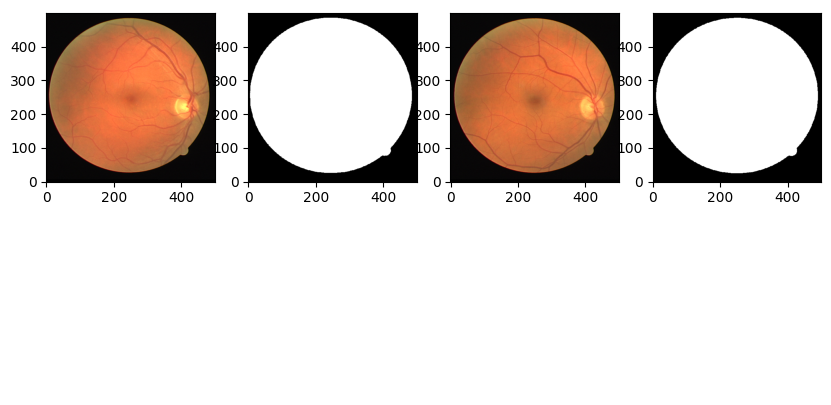

In [ ]:
figure = plt.figure(figsize=(10, 5))  # Cria o local para mostrar as imagens
# Não mostra valores para os eixos X e Y
plt.axis("off")
cols, rows = 4, 2  # Irá mostrar 2 imagens com suas anotações em uma grade 4x1

# Carrega um lote de imagens e de anotações de treino
X,y = LoteDeImagens(pasta_data,nomes_treino,tamanho_lote)

# Passa por cada imagem do lote
for i in range(0,len(X)):
    # Pega um imagem e sua anotação
    imagem = X[i]
    anotacao = y[i]

    # Adiciona a imagem na grade que será mostrada
    # Tem que ajustar a ordem das dimensões do tensor para que os canais
    # fiquem na última dimensão (e não ma primeira)
    figure.add_subplot(rows, cols, i*2+1)
    plt.imshow(imagem.permute(1,2,0),origin='lower')
    # Adiciona anotação ao lado da imagem
    figure.add_subplot(rows, cols, i*2+2)
    plt.imshow(anotacao.squeeze().numpy(),cmap='gray',origin='lower')
    
plt.show() # Este é o comando que vai mostrar as imagens

## Definindo uma rede neural artificial

In [ ]:
#@title
# Verifica se tem GPU na máquina, caso contrário, usa a CPU mesmo
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Usando {device}")

# Inicia com a rede escolhida (acrescente mais "ifs" para outras redes)
# Carrega os pesos pré-treinados na ImageNet (transfer learning)
# Ajusta a última camada para poder corresponder ao total de classes do
# problema atual. 
if nome_rede == "deeplabv3":
   model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)
   # Muda a camada final para um problema com 2 classes
   model.classifier[4] = torch.nn.Conv2d(256, len(classes), kernel_size=(1, 1), stride=(1, 1)) 
elif nome_rede == "fcn":
   model = torchvision.models.segmentation.fcn_resnet50(pretrained=True)
   model.classifier[4] = torch.nn.Conv2d(512, len(classes), kernel_size=(1, 1), stride=(1, 1)) 
   #model = torchvision.models.segmentation.fcn_resnet50(pretrained=True, num_classes=len(classes))
        

# Prepara a rede para o dispositivo que irá processá-la
model = model.to(device)

# Imprime dados sobre a arquitetura da rede
print(model)

# Define o otimizador como sendo o de estimativa adaptativa do momento (ADAM)
otimizador = torch.optim.Adam(model.parameters(), lr=taxa_aprendizagem)
# Descomente a linha de baixo se quiser usar descida de gradiente estocástica (SGD)
# otimizador = torch.optim.SGD(model.parameters(), lr=taxa_aprendizagem, momentum=momento)

# Define a função de perda como entropia cruzada
funcao_perda = nn.CrossEntropyLoss()

# Cria o módulo do tensorboard de coleta de dados
writer = SummaryWriter()

# Define a função para treinar a rede
# pasta = pasta onde estão as imagens
# nomes = lista com os nomes das imagens do conjunto de treinamento
# model = arquitetura da rede
# loss_fn = função de perda
# optimizer = otimizador 
def train(pasta, nomes, model, loss_fn, optimizer):


    size = len(nomes)  # Total de imagens
    num_batches = int(size/tamanho_lote)   # Total de lotes
    pixels = num_batches*tamanho_lote*tamanho_imagens*tamanho_imagens

    model.train()  # Avisa que a rede vai entrar em modo de aprendizagem

    train_loss, train_correct = 0, 0  # Usado para calcular perda e acurácia médias

    # Pega um lote de imagens de cada vez do conjunto de treinamento
    for batch in range(0,num_batches):

        X,y = LoteDeImagens(pasta,nomes,tamanho_lote)
        X, y = X.to(device), y.to(device)  # Prepara os dados para o dispositivo (GPU ou CPU)
        pred = model(X)['out']    # Realiza uma previsão usando os pesos atuais
        loss = loss_fn(pred, y.long())  # Calcula o erro com os pesos atuais

        train_loss += loss.item() # Guarda para calcular a perda média
        # Calcula os acertos para o lote inteiro de imagens
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item() 

        loss.backward()        # Calcula os gradientes com base no erro (loss)
        optimizer.step()       # Ajusta os pesos com base nos gradientes
        optimizer.zero_grad()  # Zera os gradientes pois vai acumular para todas
                               # as imagens do lote

        # Imprime informação a cada 1 lote processado
        if batch % 1 == 0:
            # Mostra a perda e o total de imagens já processadas
            loss, current = loss.item(), batch * len(X)
            print(f"Perda Treino: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    train_loss /= num_batches  # Como a perda foi calculada por lote, divide
                               # pelo total de lotes para calcular a média
    train_acuracia = train_correct / pixels # Já o total de acertos é em relação
                                            # ao total geral de pixels

    return train_loss, train_acuracia        

# Define a função de validação (aqui a rede não está aprendendo, apenas
# usando "aquilo que aprendeu", mas em um conjunto de imagens diferente
# do conjunto usado para aprender)
def validation(pasta, nomes, model, loss_fn):


    size = len(nomes)  # Total de imagens
    print('Total de imagens:',size)
    num_batches = int(size/tamanho_lote)   # Total de lotes
    print('Total de lotes:',num_batches)
    pixels = num_batches*tamanho_lote*tamanho_imagens*tamanho_imagens
    model.eval()  # Avisa que a rede vai entrar em modo de aprendizagem


    # Vai calcular a perda e o total de acertos no conjunto de validação
    val_loss, val_correct = 0, 0

    # Na validação os pesos não são ajustados e por isso não precisa
    # calcular o gradiente
    with torch.no_grad():
        # Pega um lote de imagens de cada vez do conjunto de treinamento
        for batch in range(0,num_batches):

            X,y = LoteDeImagens(pasta,nomes,tamanho_lote)
            X, y = X.to(device), y.to(device)  # Prepara os dados para o dispositivo (GPU ou CPU)
            pred = model(X)['out']    # Realiza uma previsão usando os pesos atuais
            val_loss += loss_fn(pred, y.long()).item()
            val_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= num_batches
    val_acuracia = val_correct / pixels

    print("Informações na Validação:")
    print(f"Total de acertos: {int(val_correct)}")
    print(f"Total de pixels: {pixels}")
    print(f"Perda média: {val_loss:>8f}")            
    print(f"Acurácia: {(100*val_acuracia)}%")
    return val_loss, val_acuracia

In [ ]:
import os
import shutil

# Pasta de origem dos arquivos .json
pasta_origem = "/content/drive/MyDrive/compara_segmentadores/data2/A/G1020/imagens"

# Pasta de destino dos arquivos .json
pasta_destino = "/content/drive/MyDrive/compara_segmentadores/data2/A/G1020/jsones"

# Cria a pasta de destino se ela não existir
if not os.path.exists(pasta_destino):
    os.makedirs(pasta_destino)

# Percorre todos os arquivos na pasta de origem
for arquivo in os.listdir(pasta_origem):
    # Verifica se o arquivo possui a extensão .json
    if arquivo.endswith(".json"):
        # Monta os caminhos completos do arquivo de origem e destino
        caminho_origem = os.path.join(pasta_origem, arquivo)
        caminho_destino = os.path.join(pasta_destino, arquivo)
        
        # Move o arquivo para a pasta de destino
        shutil.move(caminho_origem, caminho_destino)

print("Arquivos .json movidos com sucesso!")


Arquivos .json movidos com sucesso!


## Treinando a Rede Neural (Aprendizagem)

In [ ]:
# A aprendizagem agora tem parada antecipada (early stopping)

maior_acuracia = 0  # Guarda a melhor acurácia no conjunto de validação
total_sem_melhora = 0  # Guarda quantas épocas passou sem melhoria na acurácia

# Passa por todas as imagens várias vezes (a quantidade de vezes
# é definida pelo hiperparâmetro "epocas")
for epoca in range(epocas):
    print(f"-------------------------------")
    print(f"Época {epoca+1} \n-------------------------------")
    train_loss, train_acuracia = train(pasta_data,nomes_treino, model, funcao_perda, otimizador)
    val_loss, val_acuracia = validation(pasta_data,nomes_val, model, funcao_perda)

    # Guarda informações para o tensorboard pode criar os gráficos depois
    writer.add_scalars('Loss', {'train':train_loss,'val':val_loss}, epoca)
    writer.add_scalars('Accuracy', {'train':train_acuracia,'val':val_acuracia}, epoca)

    # Soma uma tolerancia no valor da maior acurácia para que melhoras muito
    # pequenas não sejam consideradas
    if val_acuracia > (maior_acuracia+tolerancia): 
      # Salva a melhor rede encontrada até o momento
      torch.save(model.state_dict(), pasta_data+"modelo_treinado_"+nome_rede+".pth")
      print("Salvou o modelo com a maior acurácia na validação até agora em modelo_treinado_"+nome_rede+".pth")      
      maior_acuracia = val_acuracia
      total_sem_melhora = 0
    else: 
      total_sem_melhora += 1 
      print(f"Sem melhora há {total_sem_melhora} épocas ({100*val_acuracia}% <= {100*(maior_acuracia+tolerancia)}%)")
    if total_sem_melhora > paciencia:
      print(f"Acabou a paciência com {epoca+1} épocas ")
      break

print("Terminou a fase de aprendizagem !")

# Pega algumas imagens para o tensorboard mostrar depois
# images,anotacoes = LoteDeImagens(pasta_data,nomes_treino,tamanho_lote)
# images = images.to(device)
# anotacoes = anotacoes.to(device)
# Cria uma grade de imagens para o tensorboard
# img_grid = torchvision.utils.make_grid(images)
# writer.add_image('Minhas Imagens', img_grid)
# writer.add_graph(model, images)
writer.close()

-------------------------------
Época 1 
-------------------------------
11.png
32.png
Perda Treino: 0.625000  [    0/   22]
33.png
18.png
Perda Treino: 3.380799  [    2/   22]
33.png
27.png
Perda Treino: 4.208532  [    4/   22]
07.png
28.png
Perda Treino: 0.309800  [    6/   22]
11.png
06.png
Perda Treino: 0.289307  [    8/   22]
04.png
11.png
Perda Treino: 0.255687  [   10/   22]
27.png
18.png
Perda Treino: 0.083754  [   12/   22]
04.png
06.png
Perda Treino: 0.080482  [   14/   22]
32.png
06.png
Perda Treino: 0.063388  [   16/   22]
16.png
13.png
Perda Treino: 0.041168  [   18/   22]
05.png
14.png
Perda Treino: 0.036173  [   20/   22]
Total de imagens: 10
Total de lotes: 5
21.png
19.png
26.png
03.png
21.png
24.png
26.png
34.png
25.png
26.png
Informações na Validação:
Total de acertos: 776357
Total de pixels: 2500000
Perda média: 334428033947952768.000000
Acurácia: 31.054280000000002%
Salvou o modelo com a maior acurácia na validação até agora em modelo_treinado_fcn.pth
--------------

## Visualização usando Tensorboard


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

## Carregando a rede treinada anteriormente e usando








In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')


# Salvar pesos do modelo treinado
torch.save(model.state_dict(), '/content/gdrive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/modelo_treinado_fcn')

# Carregar pesos do modelo treinado
model.load_state_dict(torch.load('/content/gdrive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/modelo_treinado_fcn'))

# Colocar o modelo em modo de avaliação
model.eval()


## Usando a rede treinada para segmentar algumas imagens 

35.png
01.png
Corretos na imagem: 249447.0
Total pixels: 250000
Acurácia na imagem, pixel a pixel: 0.997788
Corretos na imagem: 247971.0
Total pixels: 250000
Acurácia na imagem, pixel a pixel: 0.991884


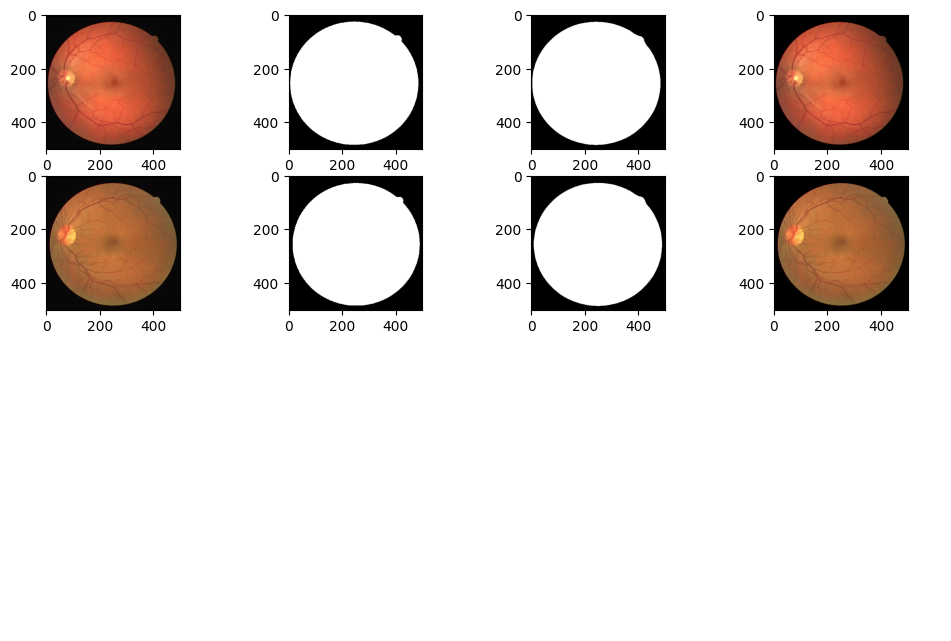

In [ ]:
# Classifica uma única imagem 
# model: rede a ser usada
# x: imagem
# y: classificação real da imagem
# predita: classificação dada pela rede
import os
import numpy as np
import matplotlib.pyplot as plt

def classifica_uma_imagem(model,x):
    model.eval()
    x = x.to(device) 

    with torch.no_grad():
       predita = model(torch.unsqueeze(x, dim=0))['out']

    return(predita)


figure = plt.figure(figsize=(12, 8))  # Cria o local para mostrar as imagens
# Não mostra valores para os eixos X e Y
plt.axis("off")
cols, rows = 4, 4  # Irá mostrar imagens com suas anotações em uma grade 4x2

# Carrega um lote de imagens e de anotações de treino
X,y = LoteDeImagens(pasta_data,nomes_teste,tamanho_lote)

# Passa por cada imagem do lote
for i in range(0,len(X)):
    # Pega um imagem e sua anotação
    imagem = X[i]
    anotacao = y[i]

    # Classifica a imagem usando a rede treinada
    predita = classifica_uma_imagem(model,imagem)
    pixels = tamanho_imagens*tamanho_imagens

    corretos = (predita.argmax(1) == anotacao.to(device)).type(torch.float).sum().item()
    print('Corretos na imagem:',corretos)
    print('Total pixels:', pixels)
    print('Acurácia na imagem, pixel a pixel:',corretos/pixels)

    predita = predita.argmax(1).squeeze()
    # Adiciona a imagem na grade que será mostrada
    # Tem que ajustar a ordem das dimensões do tensor para que os canais
    # fiquem na última dimensão (e não ma primeira)
    figure.add_subplot(rows, cols, i*4+1)
    plt.imshow(imagem.permute(1,2,0))
    # Adiciona anotação real ao lado da imagem
    figure.add_subplot(rows, cols, i*4+2)
    plt.imshow(anotacao.squeeze().numpy(),cmap='gray',origin='upper')
    # Adiciona anotação predita ao lado da anotacao real
    figure.add_subplot(rows, cols, i*4+3)
    plt.imshow(predita.cpu().numpy(),cmap='gray',origin='upper')
    # Adiciona a máscara predita sobreposta à imagem original
    sobreposta = imagem.cpu() * predita.cpu()
    figure.add_subplot(rows, cols, i*4+4)
    plt.imshow(sobreposta.permute(1,2,0))
    
plt.show() # Este é o comando que vai mostrar as imagens

In [ ]:
## Gerando algumas estatísticas no conjunto de teste

In [ ]:
# Listas para guardar valores preditos e reais
predicoes = []
reais = []

size = len(nomes_teste)  # Total de imagens
num_batches = int(size/tamanho_lote)   # Total de lotes
pixels = num_batches*tamanho_lote*tamanho_imagens*tamanho_imagens

# Vai acumular acertos para calcular acurácia
test_correct=0

model.eval() # Coloca a rede no modo de avaliação (e não de aprendizagem)
with torch.no_grad():   # Avisa que não devem ser calculados gradientes
   for batch in range(0,num_batches):
      X,y = LoteDeImagens(pasta_data,nomes_teste,tamanho_lote)
      X, y = X.to(device), y.to(device)  # Prepara os dados para o dispositivo (GPU ou CPU)
      predicao = model(X)['out']    # Realiza uma previsão usando os pesos atuais
      test_correct += (predicao.argmax(1) == y).type(torch.float).sum().item()     
      predicao = predicao.argmax(1)  # Pega a classe com maior valor

      predicoes.extend(predicao.flatten().tolist()) # Guarda predição na lista
      reais.extend(y.flatten().tolist())        # Guarda valor real na lista

# Acurácia no conjunto de teste
test_acuracia = test_correct/pixels

# Constroi a matriz de confusão
matriz = metrics.confusion_matrix(reais,predicoes)

# Normaliza a matriz para o intervalo 0 e 1 e arredonda em 2 casas decimais 
# cada célula
matriz_normalizada = np.round(matriz/np.sum(matriz),2)
# Transforma a matriz no formato da biblioteca PANDA
df_matriz = pd.DataFrame(matriz_normalizada, index = classes,
                     columns = [i for i in classes])

# Gera uma imagem do tipo mapa de calor
plt.figure(figsize = (12,7))
sn.heatmap(df_matriz, annot=True)
plt.savefig('matriz_confusao.png')

print('Métricas de desempenho no conjunto de teste:')
print(metrics.classification_report(reais,predicoes))

precision,recall,fscore,support=score(reais,predicoes,average='macro')
print('-----------------------------------')
print(f'Resumo para as {len(nomes_teste)} imagens de teste:')
print(f"Acertos: {int(test_correct)}")
print(f"Acurácia: {(100*test_acuracia):>0.2f}%")
print(f"Precisão: {100*precision:>0.2f}%")
print(f"Revocação: {100*recall:>0.2f}%")
print(f"Medida-F: {100*fscore:>0.2f}%")
print('-----------------------------------')


NameError: ignored

In [ ]:
os.listdir(os.path.join("/content/gdrive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/tudo/ti/"))

In [ ]:
# Listas para guardar valores preditos e reais
predicoes = []
reais = []

size = len(nomes_teste)  # Total de imagens
num_batches = int(size/tamanho_lote)   # Total de lotes
pixels = num_batches*tamanho_lote*tamanho_imagens*tamanho_imagens

# Vai acumular acertos para calcular acurácia
test_correct=0


model.eval() # Coloca a rede no modo de avaliação (e não de aprendizagem)
with torch.no_grad():   # Avisa que não devem ser calculados gradientes
   for batch in range(0,num_batches):
      X,y = LoteDeImagens(pasta_data,nomes_teste,tamanho_lote)
      X, y = X.to(device), y.to(device)  # Prepara os dados para o dispositivo (GPU ou CPU)
      predicao = model(X)['out']    # Realiza uma previsão usando os pesos atuais
      test_correct += (predicao.argmax(1) == y).type(torch.float).sum().item()     
      predicao = predicao.argmax(1)  # Pega a classe com maior valor

      predicoes.extend(predicao.flatten().tolist()) # Guarda predição na lista
      reais.extend(y.flatten().tolist())        # Guarda valor real na lista

# Calcular a acurácia tradicional
tp = 0  # Verdadeiros positivos
tn = 0  # Verdadeiros negativos
fp = 0  # Falsos positivos
fn = 0  # Falsos negativos

for i in range(len(reais)):
    if reais[i] == predicoes[i]:
        if reais[i] == 1:
            tp += 1
        else:
            tn += 1
    else:
        if reais[i] == 1:
            fn += 1
        else:
            fp += 1

acuracia = (tp + tn) / (tp + tn + fp + fn)

print('Métricas de desempenho no conjunto de teste:')
print(metrics.classification_report(reais, predicoes))
print('Acurácia:', acuracia)


image_2523.png
image_123.png
image_339.png
image_2810.png
image_609.png
image_2899.png
image_1032.png
image_470.png
image_246.png
image_3120.png
image_1387.png
image_2345.png
image_943.png
image_1356.png
image_708.png
image_1874.png
image_2611.png
image_1414.png
image_234.png
image_353.png
image_2140.png
image_2691.png
image_3124.png
image_581.png
image_2840.png
image_2689.png
image_2359.png
image_2795.png
image_3130.png
image_1144.png
image_773.png
image_1225.png
image_1328.png
image_1874.png
image_151.png
image_2189.png
image_2691.png
image_493.png
image_2365.png
image_2916.png
image_2212.png
image_2840.png
image_879.png
image_5.png
image_2623.png
image_3164.png
image_2898.png
image_2149.png
image_1722.png
image_339.png
image_1916.png
image_353.png
image_65.png
image_3120.png
image_5.png
image_1894.png
image_3167.png
image_2914.png
image_454.png
image_2426.png
image_2037.png
image_1414.png
image_304.png
image_955.png
image_151.png
image_1894.png
image_513.png
image_1432.png
image_216

In [ ]:
import os 
from google.colab import drive
drive.mount('/content/drive')
print(os.listdir(("/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/train/tudo")))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Cópia de 180.jpg', 'Cópia de 159.jpg', 'Cópia de 168.jpg', 'Cópia de 181.jpg', 'Cópia de 110.jpg', 'Cópia de 182.jpg', 'Cópia de 158.jpg', 'Cópia de 138.jpg', 'Cópia de 171.jpg', 'Cópia de 116.jpg', 'Cópia de 269.jpg', 'Cópia de 229.jpg', 'Cópia de 225.jpg', 'Cópia de 233.jpg', 'Cópia de 270.jpg', 'Cópia de 246.jpg', 'Cópia de 273.jpg', 'Cópia de 247.jpg', 'Cópia de 228.jpg', 'Cópia de 240.jpg', 'Cópia de 285.jpg', 'Cópia de 283.jpg', 'Cópia de 286.jpg', 'Cópia de 353.jpg', 'Cópia de 359.jpg', 'Cópia de 284.jpg', 'Cópia de 362.jpg', 'Cópia de 354.jpg', 'Cópia de 366.jpg', 'Cópia de 345.jpg', 'Cópia de 382.jpg', 'Cópia de 277.jpg', 'Cópia de 385.jpg', 'Cópia de 160.jpg', 'Cópia de 383.jpg', 'Cópia de 386.jpg', 'Cópia de 208.jpg', 'Cópia de 398.jpg', 'Cópia de 241.jpg', 'Cópia de 389.jpg', 'Cópia de 278.jpg', 'Cópia d

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense
from tensorflow.keras.models import Model

# Função para carregar as imagens e convertê-las em tensores
def carregar_imagens(caminhos_imagens):
    imagens = []
    for caminho_imagem in caminhos_imagens:
        imagem = cv2.imread(caminho_imagem)
        if imagem is None:
            continue
        imagem = cv2.resize(imagem, (128, 128))  # Redimensionar a imagem (ajuste conforme necessário)
        imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)  # Converter de BGR para RGB
        imagens.append(imagem)
    return np.array(imagens)

# Função para carregar as anotações (rótulos) a partir de arquivos PNG
def carregar_anotacoes(caminhos_anotacoes):
    anotacoes = []
    for caminho_anotacao in caminhos_anotacoes:
        anotacao = cv2.imread(caminho_anotacao, 0)  # Carregar imagem em escala de cinza
        if anotacao is None:
            continue
        anotacao = cv2.resize(anotacao, (128, 128))  # Redimensionar a anotação (ajuste conforme necessário)
        anotacao = anotacao / 255.0  # Normalizar a anotação (0-1)
        anotacoes.append(anotacao)
    return np.array(anotacoes)

# Definir a arquitetura do modelo Encoder-Decoder
def create_encoder_decoder_model(input_shape):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    # Decoder
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool3)
    up1 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2, 2))(conv5)
    conv6 = Conv2D(16, (3, 3), activation='relu', padding='same')(up2)
    up3 = UpSampling2D((2, 2))(conv6)
    
    outputs = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up3)
    
    model = Model(inputs, outputs)
    return model

# Caminho para a pasta do seu drive que contém as imagens
pasta_imagens = "/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/train"

# Caminho para a pasta do seu drive que contém as anotações (rótulos)
pasta_anotacoes = "/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/anotacoesTR/tudo"

pasta_teste = "/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/test/tudo"

pasta_anotateste = "/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/anotacoesTS/tudo"

# Obter uma lista de todos os arquivos de imagem na pasta
arquivos_imagens = [os.path.join(pasta_imagens, arquivo) for arquivo in os.listdir(pasta_imagens)]

# Obter uma lista de todos os arquivos de anotação na pasta
arquivos_anotacoes = [os.path.join(pasta_anotacoes, arquivo) for arquivo in os.listdir(pasta_anotacoes)]

arquivos_imagensT = [os.path.join(pasta_teste, arquivo) for arquivo in os.listdir(pasta_teste)]

arquivos_anotacoesT = [os.path.join(pasta_anotateste, arquivo) for arquivo in os.listdir(pasta_anotateste)]

print(arquivos_imagens)


# Carregar as imagens e convertê-las em tensores
imagens = carregar_imagens(arquivos_imagens)

# Carregar as anotações (rótulos) e convertê-las em tensores
anotacoes = carregar_anotacoes(arquivos_anotacoes)

# Carregar as imagens e convertê-las em tensores
imagensT = carregar_imagens(arquivos_imagensT)

# Carregar as anotações (rótulos) e convertê-las em tensores
anotacoesT = carregar_anotacoes(arquivos_anotacoesT)



# Verificar se há dados carregados
if len(imagens) == 0 or len(anotacoes) == 0 or len(imagensT) == 0 or len(anotacoesT) == 0:
    print("Nenhum dado válido encontrado. Verifique os caminhos dos arquivos.")
    exit()

# Criar o modelo Encoder-Decoder
input_shape = imagens[0].shape
model = create_encoder_decoder_model(input_shape)

# Compilar o modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo com seus dados
model.fit(imagens, anotacoes, batch_size=32, epochs=10, validation_split=0.2)

# Avaliar o modelo em um conjunto de teste separado
# X_test contém as imagens de teste
# y_test contém as anotações (rótulos) correspondentes para o conjunto de teste
loss, accuracy = model.evaluate(imagensT, anotacoesT)
print(f'Teste - Perda: {loss}, Acurácia: {accuracy}')

# Salvar o modelo treinado em um arquivo (Ed+Refuge(OrigaTR))
#nome_arquivo_modelo = "/content/drive/MyDrive/compara_segmentadores/data2/A/G1020/modoso.h5"
#model.save(nome_arquivo_modelo)
#print("Modelo salvo com sucesso!")

nome_arquivo_modelo = "/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/modosa.h5"
model.save(nome_arquivo_modelo)
print("Modelo salvo com sucesso!")

FileNotFoundError: ignored

teste de fé pro origa

In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, Compose
from PIL import Image

# Definir a classe do conjunto de dados
class GlaucomaDataset(Dataset):
    def __init__(self, root_dir, annotation_dir, transform=None, train=True):
        self.root_dir = root_dir
        self.annotation_dir = annotation_dir
        self.classes = ['classe 0', 'classe 1']
        self.transform = transform
        self.train = train
        self.images = []
        self.labels = []
        self.annotations = []
        for class_idx, class_dir in enumerate(self.classes):
            class_path = os.path.join(self.root_dir, class_dir)
            annotation_path = os.path.join(self.annotation_dir, class_dir)
            for image_name in os.listdir(class_path):
                image_path = os.path.join(class_path, image_name)
                self.images.append(image_path)
                self.labels.append(class_idx)
                annotation_name = image_name.replace('.jpg', '.txt')
                annotation_file = os.path.join(annotation_path, annotation_name)
                self.annotations.append(annotation_file)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = cv2.imread(self.images[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)
        if self.transform: 
            image = self.transform(image)
        label = self.labels[idx]
        annotation = self.annotations[idx]

        if self.train:
            return image, label, annotation
        else:
            return image, label



# Definir a arquitetura da rede neural
class GlaucomaClassifier(nn.Module):
    def __init__(self):
        super(GlaucomaClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 64 * 64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x


# Definir as transformações a serem aplicadas nas imagens
transform = Compose([
    Resize((128, 128)),
    ToTensor()
])

# Restante do código...

# Definir os caminhos para as pastas de treinamento e teste
train_folder = "/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/train"
train_annotation_folder = "/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/anotacoesTR"

test_folder = "/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/test"
test_annotation_folder = "/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/anotacoesTS"

# Criar o conjunto de dados de treinamento e teste
train_dataset = GlaucomaDataset(train_folder, train_annotation_folder, transform=transform, train=True)
test_dataset = GlaucomaDataset(test_folder, test_annotation_folder, transform=transform, train=False)

# Criar os dataloaders para carregar os dados durante o treinamento e teste
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ... o restante do código de treinamento e avaliação do modelo ...


# Criar a instância do modelo
model = GlaucomaClassifier()

# Definir a função de perda e o otimizador
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treinar o modelo
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels, _ in train_dataloader:  # Remova a variável desnecessária
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Avaliar o modelo após cada epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:  # Remova a variável desnecessária
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
            outputs = model(images)
            predicted = torch.round(outputs)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Accuracy: {accuracy:.4f}")
    # Salvar o modelo treinado
    torch.save(model.state_dict(), "/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/ops2.pth")





Epoch 1/10, Loss: 0.7057
Epoch 1/10, Accuracy: 0.6000
Epoch 2/10, Loss: 0.5538
Epoch 2/10, Accuracy: 0.6000
Epoch 3/10, Loss: 0.5850
Epoch 3/10, Accuracy: 0.6000
Epoch 4/10, Loss: 0.5660
Epoch 4/10, Accuracy: 0.6000
Epoch 5/10, Loss: 0.5385
Epoch 5/10, Accuracy: 0.6000
Epoch 6/10, Loss: 0.5464
Epoch 6/10, Accuracy: 0.6000
Epoch 7/10, Loss: 0.5303
Epoch 7/10, Accuracy: 0.6000
Epoch 8/10, Loss: 0.5137
Epoch 8/10, Accuracy: 0.5750
Epoch 9/10, Loss: 0.5375
Epoch 9/10, Accuracy: 0.6000
Epoch 10/10, Loss: 0.4929
Epoch 10/10, Accuracy: 0.6000


In [ ]:
# Supondo que 'model' seja o seu modelo treinado
torch.save(model.state_dict(), "/content/drive/MyDrive/compara_segmentadores/data2/A/G1020/modeloso")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Performance metrics on the test set:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        24
           1       0.00      0.00      0.00        16

    accuracy                           0.60        40
   macro avg       0.30      0.50      0.37        40
weighted avg       0.36      0.60      0.45        40

-----------------------------------
Summary for 40 test images:
Accuracy: 60.00%
Precision: 30.00%
Recall: 50.00%
F1-score: 37.50%
-----------------------------------


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

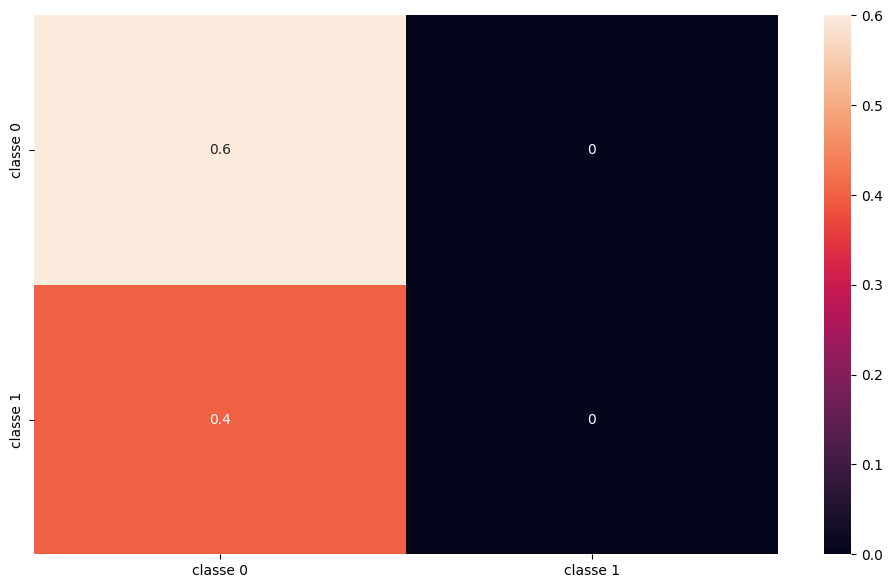

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support

# Definir a arquitetura da rede neural com transferência de aprendizado
class GlaucomaClassifier(nn.Module):
    def __init__(self):
        super(GlaucomaClassifier, self).__init__()
        self.features = torchvision.models.resnet50(pretrained=True)
        self.fc1 = nn.Linear(1000, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

# Define the desired size to resize the images
image_size = (224, 224)  # Replace with your desired sizes

# Transformation to resize the images
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load and process the test images
dataset = torchvision.datasets.ImageFolder("/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/test/", transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=False)

model = GlaucomaClassifier()

# Load the state_dict from the saved model
state_dict = torch.load('/content/drive/MyDrive/compara_segmentadores/data2/A/ORIGA/ops2.pth')

# Adjust the dimensions of fc1 in the current model
state_dict['fc1.weight'] = state_dict['fc1.weight'][:, :1000]

# Load the adjusted state_dict into the model
model.load_state_dict(state_dict, strict=False)

# Move the model to the device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Generate predictions for the test set
model.eval()
preds = []
targets = []

with torch.no_grad():
    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        _, predicted = torch.max(outputs, 1)

        preds.extend(predicted.cpu().numpy())
        targets.extend(labels.cpu().numpy())

# Calculate the confusion matrix
confusion_mat = confusion_matrix(targets, preds)

# Normalize the matrix to the range 0 and 1 and round each cell to 2 decimal places
normalized_mat = np.round(confusion_mat / np.sum(confusion_mat), 2)

# Convert the matrix to the format expected by the Pandas library
classes = dataset.classes
df_confusion = pd.DataFrame(normalized_mat, index=classes, columns=[i for i in classes])

# Generate a heatmap image
plt.figure(figsize=(12, 7))
sn.heatmap(df_confusion, annot=True)
plt.savefig('confusion_matrix.png')

# Print performance metrics
print('Performance metrics on the test set:')
print(classification_report(targets, preds))

precision, recall, fscore, support = precision_recall_fscore_support(targets, preds, average='macro')

print('-----------------------------------')
print(f'Summary for {len(dataset)} test images:')
print(f"Accuracy: {(100 * np.sum(np.array(preds) == np.array(targets)) / len(targets)):.2f}%")
print(f"Precision: {100 * precision:.2f}%")
print(f"Recall: {100 * recall:.2f}%")
print(f"F1-score: {100 * fscore:.2f}%")
print('-----------------------------------')


In [ ]:
import os
from PIL import Image

def convert_tiff_to_png(input_folder, output_folder):
    # Verifica se a pasta de saída existe, caso contrário, cria-a
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Percorre todos os arquivos na pasta de entrada
    for filename in os.listdir(input_folder):
        if filename.endswith(".tiff") or filename.endswith(".tif") or filename.endswith(".gif"):
            # Monta o caminho completo para o arquivo de entrada
            input_path = os.path.join(input_folder, filename)

            # Abre o arquivo TIFF usando o PIL
            image = Image.open(input_path)

            # Converte e salva o arquivo como PNG
            output_filename = os.path.splitext(filename)[0] + ".png"
            output_path = os.path.join(output_folder, output_filename)
            image.save(output_path, "PNG")

            print(f"Arquivo convertido: {output_filename}")

# Exemplo de uso
input_folder = "/content/gdrive/MyDrive/compara_segmentadores/data2/A/DRIVE/training/images"
output_folder = "/content/gdrive/MyDrive/compara_segmentadores/data2/A/DRIVEpng/training/images"

convert_tiff_to_png(input_folder, output_folder)


Arquivo convertido: 27_training.png
Arquivo convertido: 23_training.png
Arquivo convertido: 35_training.png
Arquivo convertido: 33_training.png
Arquivo convertido: 28_training.png
Arquivo convertido: 32_training.png
Arquivo convertido: 36_training.png
Arquivo convertido: 37_training.png
Arquivo convertido: 21_training.png
Arquivo convertido: 24_training.png
Arquivo convertido: 26_training.png
Arquivo convertido: 31_training.png
Arquivo convertido: 29_training.png
Arquivo convertido: 30_training.png
Arquivo convertido: 34_training.png
Arquivo convertido: 22_training.png
Arquivo convertido: 25_training.png
Arquivo convertido: 39_training.png
Arquivo convertido: 40_training.png
Arquivo convertido: 38_training.png
